In [1]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

import os
import keras
import h5py
import librosa
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [2]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))

    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [9]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=512):
    # Transformation function
    def melspec(signal):
        if signal.ndim > 1:
            signal = signal.flatten()
        return librosa.feature.melspectrogram(y=signal, sr=44100, n_fft=n_fft, hop_length=hop_length)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    return np.array(list(tsongs))

In [10]:
def read_data(src_dir, genres, song_samples, spec_format, debug=True):
    arr_specs = []
    arr_genres = []

    # Read files from the folders
    for genre, label in genres.items():
        folder = os.path.join(src_dir, genre)
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = os.path.join(root, file)
                signal, sr = librosa.load(file_name)
                if len(signal) < song_samples:
                    print('Error in {}\nNum of samples ( >= {}): {}'.format(file_name, song_samples, len(signal)))
                signal = signal[:song_samples]
                if debug:
                    print("Reading file: {}".format(file_name))
                signals, y = splitsongs(signal, label)
                specs = spec_format(signals)
                arr_genres.extend(y)
                arr_specs.extend(specs)

    return np.array(arr_specs), np.array(arr_genres)


In [5]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Parameters
gtzan_dir = '/content/drive/MyDrive/generes_converted/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4,
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

In [12]:
X, y = read_data(gtzan_dir, genres, song_samples, to_melspectrogram, debug=True)

Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00005.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00010.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00007.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00012.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00002.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00008.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00006.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00001.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00000.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00004.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00003.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00009.au
Reading file: /content/drive/MyDrive/generes_converted/metal/metal.00011.au
Reading file

In [ ]:
# np.save('/content/drive/MyDrive/data/x_gtzan_npy.npy', X)
# np.save('/content/drive/MyDrive/data/y_gtzan_npy.npy', y)

In [13]:
X = np.load('/content/drive/MyDrive/data/x_gtzan_npy.npy')
y = np.load('/content/drive/MyDrive/data/y_gtzan_npy.npy')

In [14]:
# One hot encoding of the labels
y = to_categorical(y)

# Dataset Split

In [15]:
X_stack = np.squeeze(np.stack((X,) * 3, -1))
X_stack.shape

(18031, 128, 129, 3)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_stack, y, test_size=0.3, random_state=42, stratify = y)

In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12621, 128, 129, 3) (5410, 128, 129, 3) (12621, 10) (5410, 10)


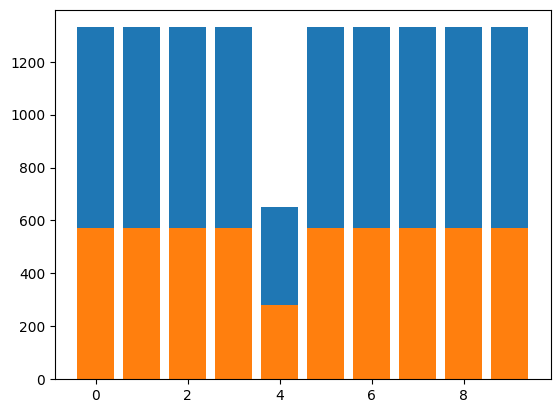

In [18]:
# Histogram for train and test
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# Training

In [19]:
# Model Definition
input_shape = X_train[0].shape
num_genres = 10

def cnn_vgg16(input_shape, num_genres, freezed_layers):
    input_tensor = Input(shape=input_shape)
    vgg16 = VGG16(include_top=False, weights='imagenet',
                  input_tensor=input_tensor)

    top = Sequential()
    top.add(Flatten(input_shape=vgg16.output_shape[1:]))
    top.add(Dense(256, activation='relu'))
    top.add(Dropout(0.5))
    top.add(Dense(num_genres, activation='softmax'))

    model = Model(inputs=vgg16.input, outputs=top(vgg16.output))
    for layer in model.layers[:freezed_layers]:
        layer.trainable = False

    return model

model = cnn_vgg16(input_shape, num_genres, 5)
print("Creating EarlyStopping Callback ...")
early_stopping_callback = EarlyStopping(monitor='val_acc', patience=5)
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Creating EarlyStopping Callback ...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 129, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 129, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 129, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                          

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

hist = model.fit(X_train, y_train,
          batch_size=128,
          epochs=1000,
          verbose=1,
          validation_data=(X_test, y_test),
          shuffle=True,
          callbacks=[early_stopping_callback])
print("Learning stoped on epoch:", early_stopping_callback.stopped_epoch)

Instructions for updating:
Use tf.cast instead.
Train on 13300 samples, validate on 5700 samples
Epoch 1/1000
13300/13300 [==============================] - 112s 8ms/step - loss: 2.1468 - acc: 0.2668 - val_loss: 1.6959 - val_acc: 0.3786
Epoch 2/1000
13300/13300 [==============================] - 93s 7ms/step - loss: 1.6221 - acc: 0.4169 - val_loss: 1.4218 - val_acc: 0.4895
Epoch 3/1000
13300/13300 [==============================] - 93s 7ms/step - loss: 1.3679 - acc: 0.5139 - val_loss: 1.1692 - val_acc: 0.5867
Epoch 4/1000
13300/13300 [==============================] - 93s 7ms/step - loss: 1.2791 - acc: 0.5429 - val_loss: 1.1145 - val_acc: 0.5981
Epoch 5/1000
13300/13300 [==============================] - 93s 7ms/step - loss: 1.1251 - acc: 0.6019 - val_loss: 0.9850 - val_acc: 0.6532
Epoch 6/1000
13300/13300 [==============================] - 93s 7ms/step - loss: 0.9795 - acc: 0.6550 - val_loss: 0.9344 - val_acc: 0.6691
Epoch 7/1000
13300/13300 [==============================] - 93s 7ms/

#Save the model

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/weights/genres_full_vgg16.h5')
print("Model saved to disk!")

Model saved to disk!


In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 0.394 and val_acc = 0.892


#Visualisation

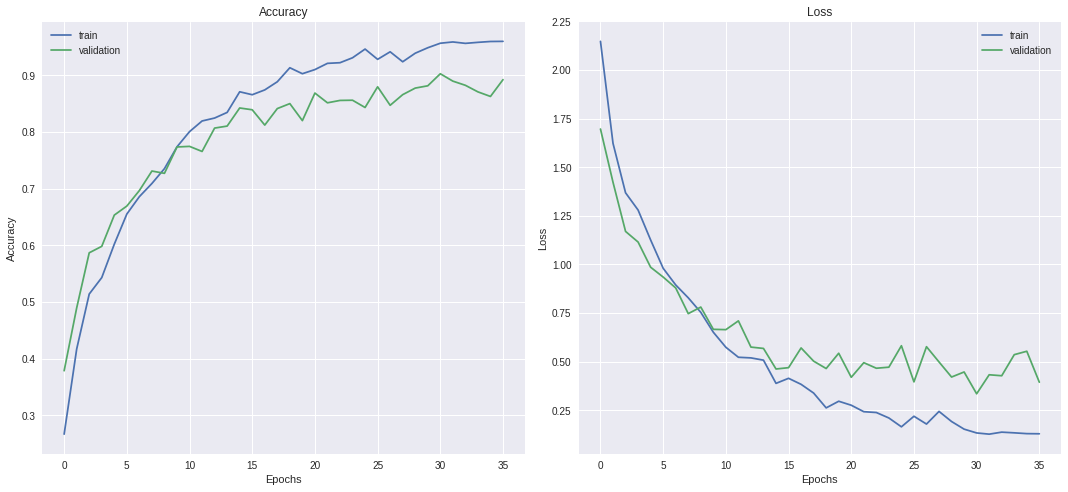

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


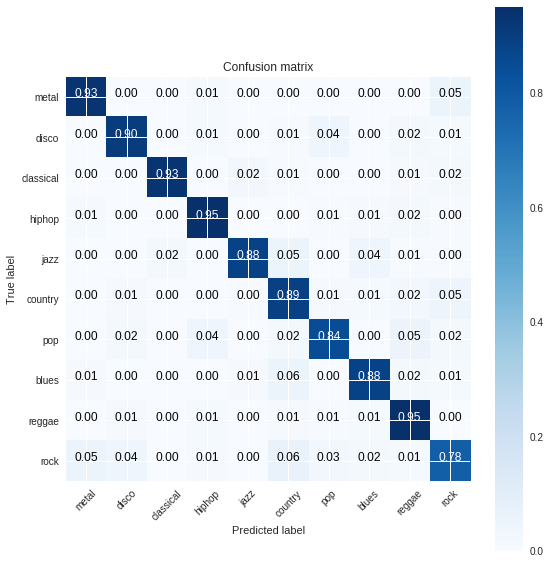

In [ ]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, keys, normalize=True)